In [2]:
!unzip saved_model.zip

Archive:  saved_model.zip
   creating: saved_model/
  inflating: __MACOSX/._saved_model  
  inflating: saved_model/.DS_Store   
  inflating: __MACOSX/saved_model/._.DS_Store  
   creating: saved_model/my_model/
  inflating: __MACOSX/saved_model/._my_model  
  inflating: saved_model/my_model/.DS_Store  
  inflating: __MACOSX/saved_model/my_model/._.DS_Store  
  inflating: saved_model/my_model/fingerprint.pb  
  inflating: __MACOSX/saved_model/my_model/._fingerprint.pb  
  inflating: saved_model/my_model/keras_metadata.pb  
  inflating: __MACOSX/saved_model/my_model/._keras_metadata.pb  
   creating: saved_model/my_model/variables/
  inflating: __MACOSX/saved_model/my_model/._variables  
  inflating: saved_model/my_model/saved_model.pb  
  inflating: __MACOSX/saved_model/my_model/._saved_model.pb  
   creating: saved_model/my_model/assets/
  inflating: __MACOSX/saved_model/my_model/._assets  
  inflating: saved_model/my_model/variables/.DS_Store  
  inflating: __MACOSX/saved_model/my_mod

In [3]:
import os

import tensorflow as tf
from tensorflow import keras

In [4]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_12[0][0]']               
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                         

In [5]:
import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt


In [6]:
import numpy as np

In [7]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteX7M0T3/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteX7M0T3/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [8]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [9]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [10]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [11]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [13]:
test_batches = test_images.batch(BATCH_SIZE)

In [14]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [15]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = new_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
      # print(dataset.size())
      # print(image.shape)
      # print(image)
      # print(mask.shape)
      # print(np.array(mask))
      # print(mask[0])

      # print(np.squeeze(mask[0]))
      # print(image[0])

      display_edit(image[0],mask[0])
      display_edit(image[0],create_mask(pred_mask))
  else:
    display([sample_image, sample_mask,
             create_mask(new_model.predict(sample_image[tf.newaxis, ...]))])

In [16]:
def display_edit(image, mask):

  img = np.array(image)

  for r in range(mask.shape[0]):
    for c in range(mask.shape[0]):
      if(mask[r][c]==1):
        img[r,c] = (0, 0, 0)
      elif(mask[r][c]==2):
        img[r,c] = (1,1,1)
  
  plt.title('Remove Background')
  plt.imshow(tf.keras.utils.array_to_img(img))
  plt.show()

2/2 [==============================] - 4s 1s/step


[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
 array([[[0.9764706 , 0.9417586 , 0.9061734 ],
         [0.9832974 , 0.9558464 , 0.9244739 ],
         [0.9855304 , 0.9567605 , 0.9247286 ],
         ...,
         [0.9946232 , 0.958318  , 0.91764706],
         [0.98910844, 0.9546875 , 0.91764706],
         [0.99215686, 0.9529412 , 0.9137255 ]],
 
        [[0.98271054, 0.9479985 , 0.91241336],
         [0.97764176, 0.9501908 , 0.91881824],
         [0.7034146 , 0.6778282 , 0.6493662 ],
         ...,
         [0.99228156, 0.9559764 , 0.91037285],
         [0.99215686, 0.9607843 , 0.91764706],
         [0.99356616, 0.9543505 , 0.9151348 ]],
 
        [[0.9801784 , 0.95272744, 0.9213549 ],
         [0.98512346, 0.94982934, 0.92237836],
         [0.985769  , 0.9554075 , 0.9254902 ],
         ...,
         [0.98862183, 0.95826036, 0.9204999 ],
         [0.99192494, 0.9566308 , 0.9213367 ],
         [0.99607843, 0.95686275, 0.91764706]],
 
        ...,
 
        [[0.28583914, 0.4387882 

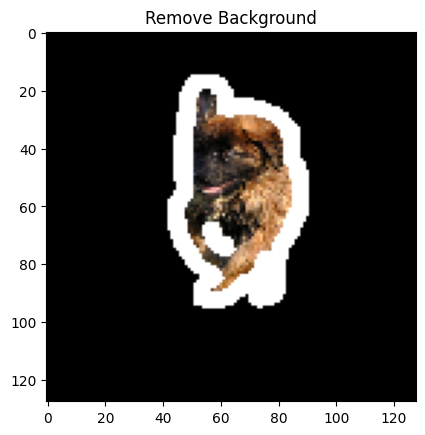

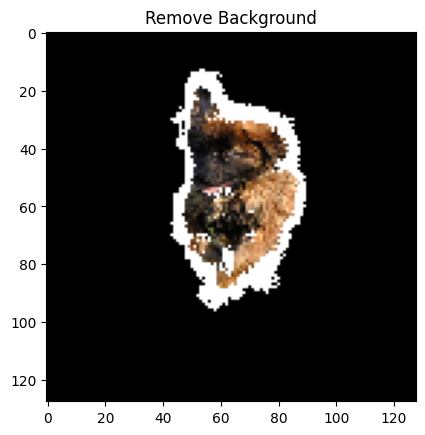

In [17]:
show_predictions(test_batches, 1)

In [18]:
# # Evaluate the restored model
# loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
# print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

# print(new_model.predict(test_images).shape)